## **<span style="color:#023e8a"><center> 📊Guided LDA. Semi-supervised TM.</center></span>**
## **<center><span style="color:#FEF1FE;background-color:#023e8a;border-radius: 5px;padding: 5px">If you find this notebook useful or interesting, please, support with an upvote :)</span></center>**

## **<span style="color:#023e8a;font-size:1000%"><center>NLP</center></span><span style="color:#023e8a;font-size:200%"><center>Topic Modeling. Guided LDA.</center></span>**
>**<span style="color:#023e8a;">Hello everyone!</span>**  
>**<span style="color:#023e8a;">I hope that this notebook will be interesting and useful for you. Guided LDA gives more opportunities to work with topic comparing with original LDA.</span>**  
>**<span style="color:#023e8a;">it can be helpful in other competitions and here like new feature. Anyway, here, I try to show how it uses.</span>**

# **<a id="Content" style="color:#023e8a;">Table of Content</a>**
* [**<span style="color:#023e8a;">1. Loading data</span>**](#Loading)  
* [**<span style="color:#023e8a;">2. Text desc and cloud of words</span>**](#Cloud) 
* [**<span style="color:#023e8a;">3. Data prep and stemming</span>**](#Data)  
* [**<span style="color:#023e8a;">4. Modeling</span>**](#Modeling)  
* [**<span style="color:#023e8a;">5. References</span>**](#References)  

# **<span style="color:#023e8a;">Imports</span>**

In [1]:
import os
import pandas as pd
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.stem import PorterStemmer
from nltk import word_tokenize
import numpy as np
from gensim.models.ldamulticore import LdaMulticore
import gensim
from nltk.corpus import stopwords
stops = stopwords.words("english")

# **<span id="Loading" style="color:#023e8a;">1. Loading data</span>**

[**<span style="color:#FEF1FE;background-color:#023e8a;border-radius: 5px;padding: 2px">Go to Table of Content</span>**](#Content)

Topic modeling is an integral part of `NLP`. If used correctly, it could give a sufficient boost to any analysis. Along with the classical LDA there is a semi-supervised alghorithm - `Guided (Seeded) LDA`.

In [2]:
def load_df():
    train_names, train_texts = [], []
    for f in tqdm(list(os.listdir('../input/feedback-prize-2021/train'))):
        train_names.append(f.replace('.txt', ''))
        train_texts.append(open('../input/feedback-prize-2021/train/' + f, 'r').read())
    train_text_df = pd.DataFrame({'id': train_names, 'text': train_texts})
    return train_text_df

df = load_df()
df.head()

  0%|          | 0/15594 [00:00<?, ?it/s]

,id,text
0,62C57C524CD2,I think we should be able to play in a sport i...
1,80667AD3FFD8,Some schools require summer projects for stude...
2,21868C40B94F,Driverless cars have been argued and talked ab...
3,87A6EF3113C6,"The author of ""The Challenge of Exploring Venu..."
4,24687D08CFDA,"Wow, from the mar really look like humans face..."


For more efficient work of `LDA` we need to lemmatize text. `Lemmatization` is necessary to bring words to their initial form. That is helpful to consider words "student" and, for instance, "students" as the same word. However, `stemming` (that is the procedure consisting in separating the root of the word only) is a is an appropriate tool for English too and in terms of the speed it is much more beneficial than `lemmatization`.

**Learn more**: https://nlp.stanford.edu/IR-book/html/htmledition/stemming-and-lemmatization-1.html

# **<span id="Cloud" style="color:#023e8a;">2. Text desc and cloud of Words</span>**

In [3]:
from wordcloud import WordCloud, STOPWORDS
from PIL import Image
import seaborn as sns

In [4]:
df['len_text'] = df['text'].apply(len)
df['text_split'] = df['text'].str.split()
df['len_words'] = df['text_split'].apply(len)

**<span style="color:#023e8a;">Histograms of word and text lens</span>**

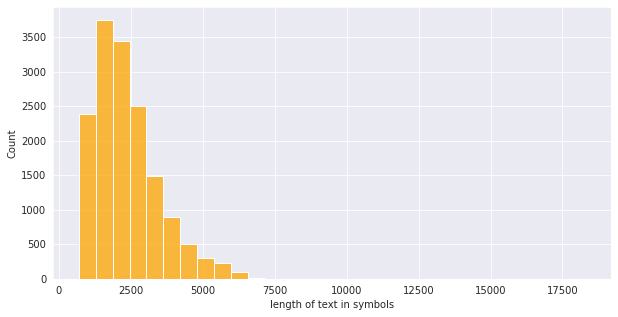

In [5]:
sns.set_style("darkgrid")
f, ax = plt.subplots(figsize=(10,5))
ax = sns.histplot(data=df, x='len_text', bins=30, color='orange')
ax.set_xlabel('length of text in symbols')
plt.show()

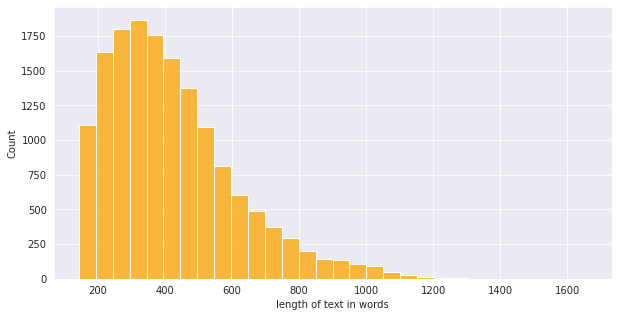

In [6]:
sns.set_style("darkgrid")
f, ax = plt.subplots(figsize=(10,5))
ax = sns.histplot(data=df, x='len_words', bins=30, color='orange')
ax.set_xlabel('length of text in words')
plt.show()

**<span style="color:#023e8a;">Both statistics have a significant right tale.</span>**

In [7]:
df[['len_text', 'len_words']].describe()

,len_text,len_words
count,15594.000000,15594.000000
mean,2364.097986,421.258048
std,1132.463751,191.065363
min,691.000000,144.000000
25%,1528.000000,278.000000
50%,2135.000000,384.000000
75%,2930.000000,520.000000
max,18322.000000,1656.000000


**<span style="color:#023e8a;">Pay attention to text with max of symbols (>> then mean).</span>**

In [8]:
df[df['len_text'] == 18322].text.values

array(['if we look back at time in the united states young people were thrilled to be able to drive. but in more recent years studies show that the young in the united states dont really have the same thrill anymore actually there really not interested at all they find alternative ways to get to were there going like public transportation carpooling biking or just good old walking and really its not a bad idea at all if we can get others in the US to limiting the use if there cars it could do the world a lotta good\n\nIf you take a look at Colombia for instience they have a day where in bogota 7 million people are banned using there cars for a day they find alternatives to get around like biking hiking walking busses and taxi cabs doing this is a good way to stop air polluion and also to promote alternatives transportation and if people violate it theres a fine of $25 a bussiness man by the name of Carlos Arturo Plaza says "its a good opportunity to take away stress and lower air pollu

**<span style="color:#023e8a;">This text contains many spaces (\xa0). Remove it.</span>**

In [9]:
df['text'] = df['text'].str.replace('\xa0', '')
df['text'] = df['text'].str.strip()

df['len_text'] = df['text'].apply(len)
df['text_split'] = df['text'].str.split()
df['len_words'] = df['text_split'].apply(len)

In [10]:
df[['len_text', 'len_words']].describe()

,len_text,len_words
count,15594.000000,15594.000000
mean,2346.489611,420.614659
std,1108.842308,190.518856
min,691.000000,144.000000
25%,1515.000000,277.000000
50%,2120.500000,384.000000
75%,2912.750000,519.000000
max,8533.000000,1656.000000


**<span style="color:#023e8a;">Now tails are less.</span>**

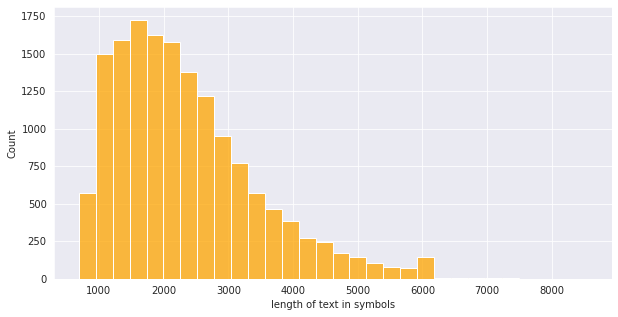

In [11]:
sns.set_style("darkgrid")
f, ax = plt.subplots(figsize=(10,5))
ax = sns.histplot(data=df, x='len_text', bins=30, color='orange')
ax.set_xlabel('length of text in symbols')
plt.show()

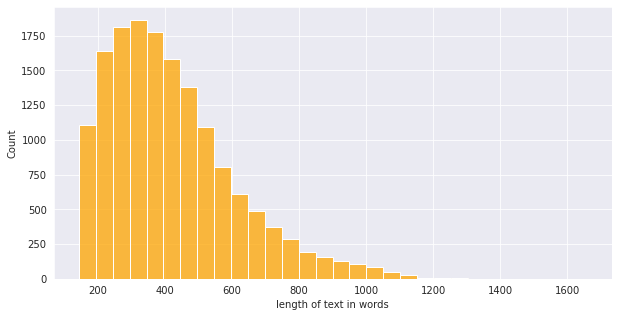

In [12]:
sns.set_style("darkgrid")
f, ax = plt.subplots(figsize=(10,5))
ax = sns.histplot(data=df, x='len_words', bins=30, color='orange')
ax.set_xlabel('length of text in words')
plt.show()

**<span style="color:#023e8a;">Using words from our data create Wordcloud</span>**

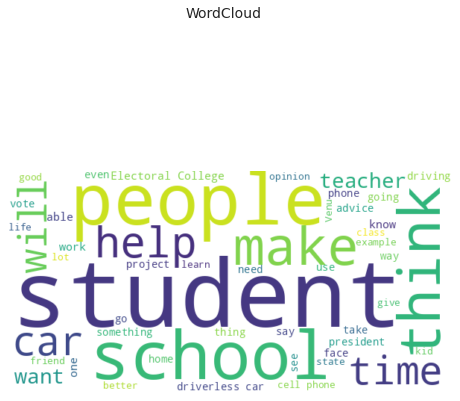

In [13]:
cloud = WordCloud(background_color="white", max_words=50, stopwords=set(STOPWORDS), width=600, height=300)
f, ax = plt.subplots(figsize=(8, 8))
f.suptitle('WordCloud', fontsize=14)
cloud = cloud.generate(' '.join(df.text.tolist()))
ax.imshow(cloud, interpolation='bilinear')
ax.axis('off')
f.show()

# **<span id="Data" style="color:#023e8a;">3. Data prep and stemming</span>**

[**<span style="color:#FEF1FE;background-color:#023e8a;border-radius: 5px;padding: 2px">Go to Table of Content</span>**](#Content)

In [14]:
text = [t.split() for t in df.text.tolist()]

In [15]:
stemmed_text = []
ps = PorterStemmer()
for sentence in tqdm(text):
    sent = []
    for word in sentence:
        sent.append(ps.stem(word))
    stemmed_text.append(sent)

  0%|          | 0/15594 [00:00<?, ?it/s]

Just compare original text and stemmed one.

In [16]:
print(*stemmed_text[5][:20])
print(*text[5][:20])

how would you feel if your child stop go to school and start from home? school are offer distanc learn
How would you feel if your child stopped going to school and started from home? Schools are offering distance learning


After that, we need to bring the words to a numerical expression. For this you can use:
* `Countvectorizer`
* `Tf-idf`
* `Embeddings`

`Countvectorizer` gives matrix num_words X texts where each number is a number of count in all texts.

`TF-IDF` is an abbreviation standing for frequency–inverse document frequency,which is a numerical statistics that are aimed to reflect how important a word is for a document in a collection or corpus. 

**Learn more**: https://towardsdatascience.com/tf-idf-for-document-ranking-from-scratch-in-python-on-real-world-dataset-796d339a4089

`Gensim` allows to get bow by method `doc2bow`. This method converts document (a list of words) into the bag-of-words format = list of (token_id, token_count) 2-tuples. 

In [17]:
dictionary = gensim.corpora.Dictionary(stemmed_text)

Filter dictionary by stopwords and most common words (more than in 70% of texts) and not frequently used words (<20 counts).

In [18]:
stopword_ids = map(dictionary.token2id.get, stops)
dictionary.filter_tokens(bad_ids=stopword_ids)
dictionary.filter_extremes(no_below=20, no_above=0.7, keep_n=None)
dictionary.compactify() # remove gaps in id sequence
bow = [dictionary.doc2bow(line) for line in tqdm(stemmed_text)]

  0%|          | 0/15594 [00:00<?, ?it/s]

`Seeded (or Guided) LDA` is a method that allows to add apriori information about the distribution of words in topics. Thus, we can get a desired topic with the given dictionary and do not depend only on the black box results.


**Learn more**: https://nlp.stanford.edu/pubs/llda-emnlp09.pdf

Just let us consider "cars" as our first topic. The second one will be politics and the last one will be devoted to school life.

In [19]:
cars = ['saloon', 'sedan', 'car', 'automobile', 'corvette', 'motor', 'wheel', 'vehicle', 'roadster', 'supercar', 'driver', 'garage', 'traffic',
       'hybrid', 'engine', 'license']
politics = ['senate', 'democracy', 'negotiation', 'power', 'party', 'government', 'convention', 'delegate', 'political', 'state']
school = ['student', 'teacher', 'principal', 'project', 'subject', 'cirriculum', 'mark', 'assesment', 'test', 'discipline', 'graduation']

school = [ps.stem(word) for word in school]
politics = [ps.stem(word) for word in politics]
cars = [ps.stem(word) for word in cars]

Prepare topics with topic words.

In [20]:
seed_topics = {}
for word in cars:
    seed_topics[word] = 0
for word in politics:
    seed_topics[word] = 1
for word in school:
    seed_topics[word] = 2

Create_eta function gives eta matrix with apriori words in topics.

In [21]:
def create_eta(priors, etadict, ntopics):
    eta = np.full(shape=(ntopics, len(etadict)), fill_value=1) # create a (ntopics, nterms) matrix and fill with 1
    for word, topic in priors.items(): # for each word in the list of priors
        keyindex = [index for index,term in etadict.items() if term==word] # look up the word in the dictionary
        if (len(keyindex)>0): # if it's in the dictionary
            eta[topic,keyindex[0]] = 1e7  # put a large number in there
    eta = np.divide(eta, eta.sum(axis=0)) # normalize so that the probabilities sum to 1 over all topics
    return eta

Number of topics = 4:
* `cars`
* `politics`
* `school life`
* `common topic`

# **<span id="Modeling" style="color:#023e8a;">4. Modeling</span>**

[**<span style="color:#FEF1FE;background-color:#023e8a;border-radius: 5px;padding: 2px">Go to Table of Content</span>**](#Content)

In [22]:
eta = create_eta(seed_topics, dictionary, 4)

In [23]:
lda_model = LdaMulticore(corpus=bow,
                         id2word=dictionary,
                         num_topics=4,
                         eta=eta,
                         chunksize=2000,
                         passes=5,
                         random_state=42,
                         alpha='symmetric',
                         per_word_topics=True)

You may change the number of topics and check `Coherence` for model selection. Moreover, you may set initially more words in topics for better results.

Topics which are concerned with cars, politics and school are easy to detect.

In [24]:
for num, params in lda_model.print_topics():
    print(f'{num}: {params}\n')

0: 0.045*"car" + 0.018*"drive" + 0.015*"peopl" + 0.012*"use" + 0.011*"phone" + 0.011*"driverless" + 0.009*"driver" + 0.008*"get" + 0.007*"could" + 0.007*"I"

1: 0.033*"elector" + 0.032*"vote" + 0.017*"colleg" + 0.015*"state" + 0.013*"peopl" + 0.012*"venu" + 0.010*"presid" + 0.010*"I" + 0.010*"elect" + 0.008*"popular"

2: 0.049*"student" + 0.023*"school" + 0.014*"I" + 0.012*"learn" + 0.011*"get" + 0.011*"class" + 0.010*"teacher" + 0.010*"project" + 0.010*"help" + 0.009*"work"

3: 0.023*"peopl" + 0.016*"I" + 0.016*"ask" + 0.015*"help" + 0.015*"make" + 0.013*"one" + 0.013*"advic" + 0.012*"wa" + 0.011*"get" + 0.011*"could"



May all of you be lucky in the competition. Hopefully, this notebook will be useful for you.

# **<span id="References" style="color:#023e8a;">5. References</span>**

https://www.kaggle.com/raghavendrakotala/fine-tunned-on-roberta-base-as-ner-problem-0-533  
https://www.kaggle.com/julian3833/topic-modeling-with-lda

## **<center><span style="color:#FEF1FE;background-color:#023e8a;border-radius: 5px;padding: 5px">Thanks for reading! If you find this notebook useful or interesting, please, support with an upvote :)</span></center>**